In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [3]:
import numpy as np 
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio

In [4]:
dataset_path = Path("C:\\Users\\susma\\Documents\\kerasseedlings")
images = list(dataset_path.glob(r'**/*.png'))
labels = list(map(lambda x: x.parents[0].stem, images))

In [6]:
images = pd.Series(images, name="Images").astype(str)
labels = pd.Series(labels, name="Labels").astype(str)

data = pd.concat([images, labels], axis = 1)
data = data.sample(frac = 1, random_state = 42).reset_index(drop = True)
data.head()

,Images,Labels
0,C:\Users\susma\Documents\kerasseedlings\Train\...,Small-flowered Cranesbill
1,C:\Users\susma\Documents\kerasseedlings\Train\...,Common Chickweed
2,C:\Users\susma\Documents\kerasseedlings\Train\...,Charlock
3,C:\Users\susma\Documents\kerasseedlings\Train\...,Fat Hen
4,C:\Users\susma\Documents\kerasseedlings\Train\...,Common wheat


fig, axes = plt.subplots(2, 2, figsize = (8, 8))
for i, ax in enumerate(axes.flat):
  ax.imshow(imageio.imread(data.Images[i]))
  ax.set_title(data.Labels[i])
  ax.set_xticks([])
  ax.set_yticks([])
plt.tight_layout()
plt.show()

In [25]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import mobilenet_v2

train_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input,
    validation_split = 0.2
)

test_generator_mobile_net = ImageDataGenerator(
    preprocessing_function = mobilenet_v2.preprocess_input
)

In [26]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    data, 
    train_size=0.8, 
    shuffle=True, 
    random_state=42,
    stratify=data[["Labels"]]
)
train = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='training',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)
validation = train_generator_mobile_net.flow_from_dataframe(
    dataframe=train_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=True,
    seed=42,
    subset='validation',
    rotation_range=32,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    sheer_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test = test_generator_mobile_net.flow_from_dataframe(
    dataframe=test_df,
    x_col="Images",
    y_col="Labels",
    target_size=(224, 224),
    color_mode="rgb",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
)

Found 3040 validated image filenames belonging to 12 classes.
Found 760 validated image filenames belonging to 12 classes.
Found 950 validated image filenames belonging to 12 classes.


In [27]:
from tensorflow.keras.applications import MobileNetV2

mobilenet_ = MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    alpha=1.0,
    weights='imagenet',
    pooling='avg'
)

mobilenet_.trainable = False

In [28]:
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

# building the Predictor layers
x = Dense(256, activation='relu')(mobilenet_.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)

outputs = Dense(12, activation='softmax')(x)

mobilenet = Model(inputs=mobilenet_.inputs, outputs=outputs)

mobilenet.compile(
    optimizer=Adam(),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy()]
)

In [29]:
CHECKPOINTS = Path("./checkpoints")
CHECKPOINTS.mkdir(exist_ok=True)

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
results = mobilenet.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 10,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), 
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
            str(CHECKPOINTS),
            monitor="val_loss",
            save_best_only=True
        ),
    ]
)
results = mobilenet.fit(
    train,
    validation_data = validation,
    batch_size = 32,
    epochs = 10,
    callbacks = [
        EarlyStopping(
            monitor="val_loss",
            patience=4,
            restore_best_weights=True
        ), 
        ReduceLROnPlateau(patience=2),
        ModelCheckpoint(
            str(CHECKPOINTS),
            monitor="val_loss",
            save_best_only=True
        ),
    ]
)



Epoch 1/10
95/95 [==============================] - ETA: 0s - loss: 0.7668 - categorical_accuracy: 0.7322

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


95/95 [==============================] - 67s 704ms/step - loss: 0.7668 - categorical_accuracy: 0.7322 - val_loss: 0.6201 - val_categorical_accuracy: 0.7934 - lr: 0.0010
Epoch 2/10
95/95 [==============================] - ETA: 0s - loss: 0.5413 - categorical_accuracy: 0.8132

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


95/95 [==============================] - 66s 699ms/step - loss: 0.5413 - categorical_accuracy: 0.8132 - val_loss: 0.5466 - val_categorical_accuracy: 0.8118 - lr: 0.0010
Epoch 3/10
95/95 [==============================] - ETA: 0s - loss: 0.4440 - categorical_accuracy: 0.8391

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


95/95 [==============================] - 67s 709ms/step - loss: 0.4440 - categorical_accuracy: 0.8391 - val_loss: 0.5001 - val_categorical_accuracy: 0.8316 - lr: 0.0010
Epoch 4/10
95/95 [==============================] - 53s 556ms/step - loss: 0.3921 - categorical_accuracy: 0.8638 - val_loss: 0.5189 - val_categorical_accuracy: 0.8184 - lr: 0.0010
Epoch 5/10
95/95 [==============================] - ETA: 0s - loss: 0.3277 - categorical_accuracy: 0.8895

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


95/95 [==============================] - 64s 676ms/step - loss: 0.3277 - categorical_accuracy: 0.8895 - val_loss: 0.4768 - val_categorical_accuracy: 0.8382 - lr: 0.0010
Epoch 6/10
95/95 [==============================] - 55s 573ms/step - loss: 0.2877 - categorical_accuracy: 0.9000 - val_loss: 0.5170 - val_categorical_accuracy: 0.8158 - lr: 0.0010
Epoch 7/10
95/95 [==============================] - 56s 585ms/step - loss: 0.2513 - categorical_accuracy: 0.9125 - val_loss: 0.4860 - val_categorical_accuracy: 0.8329 - lr: 0.0010
Epoch 8/10
95/95 [==============================] - ETA: 0s - loss: 0.1582 - categorical_accuracy: 0.9480

INFO:tensorflow:Assets written to: checkpoints\assets


INFO:tensorflow:Assets written to: checkpoints\assets


95/95 [==============================] - 68s 717ms/step - loss: 0.1582 - categorical_accuracy: 0.9480 - val_loss: 0.4207 - val_categorical_accuracy: 0.8618 - lr: 1.0000e-04
Epoch 9/10
95/95 [==============================] - 54s 564ms/step - loss: 0.1291 - categorical_accuracy: 0.9612 - val_loss: 0.4211 - val_categorical_accuracy: 0.8618 - lr: 1.0000e-04
Epoch 10/10
95/95 [==============================] - 54s 567ms/step - loss: 0.1126 - categorical_accuracy: 0.9674 - val_loss: 0.4315 - val_categorical_accuracy: 0.8632 - lr: 1.0000e-04
Epoch 1/10
42/95 [============>.................] - ETA: 23s - loss: 0.1018 - categorical_accuracy: 0.9732

KeyboardInterrupt: 

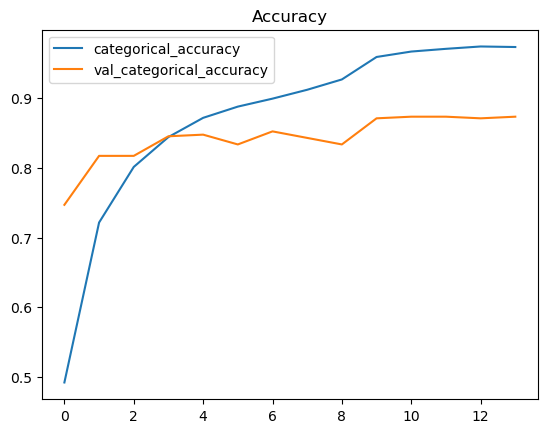

In [13]:
pd.DataFrame(results.history)[['categorical_accuracy', 'val_categorical_accuracy']].plot()
plt.title("Accuracy")
plt.show()

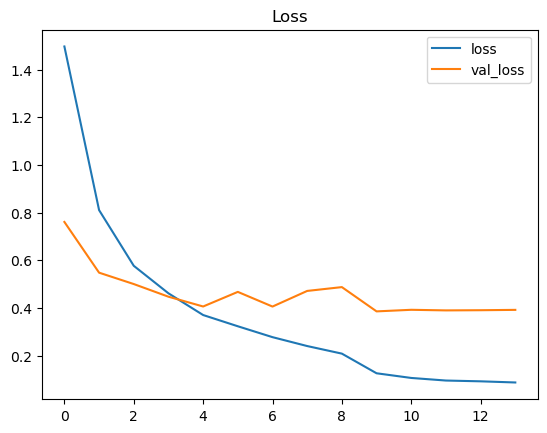

In [14]:
pd.DataFrame(results.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.show()

In [15]:
MODEL_PATH = Path("./saved_model")
MODEL_PATH.mkdir(exist_ok=True)
mobilenet.save(str(MODEL_PATH))

INFO:tensorflow:Assets written to: saved_model\assets


INFO:tensorflow:Assets written to: saved_model\assets


In [16]:
np.save('model_history.npy', results.history)

In [17]:
results = mobilenet.evaluate(test)


15/15 [==============================] - 16s 1s/step - loss: 0.3627 - categorical_accuracy: 0.8800


In [18]:
predictions = np.argmax(mobilenet.predict(test), axis=1)

15/15 [==============================] - 13s 744ms/step


In [19]:
from sklearn.metrics import classification_report
labels = dict((v, k) for k, v in train.class_indices.items())
actual = list(test_df.Labels)
predictions = [labels[i] for i in predictions]
print(classification_report(actual, predictions))

                           precision    recall  f1-score   support

              Black-grass       0.80      0.62      0.70        26
                 Charlock       1.00      0.97      0.99        39
                 Cleavers       0.93      0.90      0.91        29
         Common Chickweed       0.83      0.85      0.84        61
             Common wheat       0.95      0.86      0.90        22
                  Fat Hen       0.84      0.85      0.85        48
         Loose Silky-bent       0.84      0.95      0.89        65
                    Maize       0.95      0.86      0.90        22
        Scentless Mayweed       0.86      0.85      0.85        52
          Shepherds Purse       0.83      0.83      0.83        23
Small-flowered Cranesbill       0.96      0.96      0.96        50
               Sugar beet       0.87      0.89      0.88        38

                 accuracy                           0.88       475
                macro avg       0.89      0.87      0.88    